## Importing Libraries -

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# For NLP -
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## Let's read the dataset -

In [2]:
# There are some characters in the dataset which need latin1 encoding (default utf-8 encoding doesn't work)
twitter = pd.read_csv("data/twitter_gender.csv",encoding="latin1")

twitter.columns

twitter.head()

# Let's see if there are any duplicates

twitter.drop_duplicates(subset='_unit_id',inplace=True)

### Analysis -

Let's look at the metadata -

The dataset contains the following fields:

- unitid: a unique id for user
- _golden: whether the user was included in the gold standard for the model; TRUE or FALSE
- unitstate: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
- trustedjudgments: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
- lastjudgment_at: date and time of last contributor judgment; blank for gold standard observations
- gender: one of male, female, or brand (for non-human profiles)
- gender:confidence: a float representing confidence in the provided gender
- profile_yn: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
- profile_yn:confidence: confidence in the existence/non-existence of the profile
- created: date and time when the profile was created
- description: the user's profile description
- fav_number: number of tweets the user has favorited
- gender_gold: if the profile is golden, what is the gender?
- link_color: the link color on the profile, as a hex value
- name: the user's name
- profileyngold: whether the profile y/n value is golden
- profileimage: a link to the profile image
- retweet_count: number of times the user has retweeted (or possibly, been retweeted)
- sidebar_color: color of the profile sidebar, as a hex value
- text: text of a random one of the user's tweets
- tweet_coord: if the user has location turned on, the coordinates as a string with the format  "[latitude, longitude]"
- tweet_count: number of tweets that the user has posted
- tweet_created: when the random tweet (in the text column) was created
- tweet_id: the tweet id of the random tweet
- tweet_location: location of the tweet; seems to not be particularly normalized
- user_timezone: the timezone of the user

### Analysis -

Let's look at the metadata -

The dataset contains the following fields:

- unitid: a unique id for user
- gender: one of male, female, or brand 
  (for non-human profiles)
- gender:confidence: a float representing 
  confidence 
  in the provided gender
- description: the user's profile description
- fav_number: number of tweets the user 
  has favorited
- name: the user's name
- retweet_count: number of times the user 
  has retweeted 
  (or possibly, been retweeted)
- sidebar_color: color of the profile sidebar, 
  as a hex value
- text: text of a random one of the user's tweets
- tweet_count: number of tweets that the user 
  has posted

The column gender:confidence tells us how confident each user is in the gender of the profile

Let's only train our model on the observations which have confidence = 1

In [3]:
twitter_conf = twitter[twitter.loc[:,"gender:confidence"]==1]
# We need to reset the index -
twitter_conf.reset_index(drop=True, inplace=True)
twitter_conf

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719229,False,finalized,3,10/26/15 23:10,male,1.0,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
3,815719230,False,finalized,3,10/27/15 1:15,female,1.0,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
4,815719231,False,finalized,3,10/27/15 1:47,female,1.0,yes,1.0,3/11/10 18:14,...,https://pbs.twimg.com/profile_images/656336865...,0,0,"Ive seen people on the train with lamps, chair...",NaN,20036,10/26/15 12:40,6.587300e+17,New York Gritty,Central Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,815756767,True,golden,227,NaN,female,1.0,yes,1.0,6/11/14 1:55,...,https://pbs.twimg.com/profile_images/643483977...,0,C0DEED,Need A Ride Home From Practice _Ù÷Ô_Ù÷Ô_Ù÷ÔAnd...,NaN,6669,10/26/15 13:19,6.587400e+17,NaN,NaN
13922,815757572,True,golden,259,NaN,female,1.0,yes,1.0,8/5/15 21:16,...,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
13923,815757681,True,golden,248,NaN,male,1.0,yes,1.0,8/15/12 21:17,...,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
13924,815757830,True,golden,264,NaN,male,1.0,yes,1.0,9/3/12 1:17,...,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN


From this dataset, let's see if we can predict the gender {male, female, brand} based on description using the bag of words model

In [43]:
# Get 'description' only corpus -

twitter_desc = pd.concat([twitter._unit_id, twitter_conf.gender, twitter_conf.description], axis=1)
twitter_desc

# Let's check for NAs and drop them (and then reset index)

twitter_desc.dropna(inplace=True)
twitter_desc.reset_index(drop=True, inplace=True)
twitter_desc['description'].iloc[1]

"I'm the author of novels filled with family drama and romance."

In [44]:
twitter_desc['description'].iloc[1]

"I'm the author of novels filled with family drama and romance."

In [134]:
twitter_desc['gender'].unique()
mask = twitter_desc['gender']!='unknown'
twitter_desc = twitter_desc[mask]
twitter_desc.reset_index(drop=True, inplace=True)
twitter_desc


,_unit_id,gender,description
0,815719226,male,i sing my own rhythm.
1,815719227,male,I'm the author of novels filled with family dr...
2,815719228,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
3,815719229,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...
4,815719230,female,you don't know me.
...,...,...,...
11768,815733376,female,I Love Me...Myself....&....I
11769,815733377,female,(rp)
11770,815733378,male,"Whatever you like, it's not a problem at all. ..."
11771,815733379,male,#TeamBarcelona ..You look lost so you should f...


In [58]:
corpus = []
for i in range(0, len(twitter_desc)):
    desc = re.sub('[^a-zA-Z]', ' ', twitter_desc['description'][i])
    desc = desc.lower()
    desc = desc.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.append("co")
    desc = [ps.stem(word) for word in desc if not word in set(all_stopwords)]
    desc = ' '.join(desc)
    corpus.append(desc)
    


    
# Get separate corpus for male, female, brands

mask_male = twitter_desc['gender']=='male'
mask_female = twitter_desc['gender']=='female'
mask_brand = twitter_desc['gender']=='brand'

twitter_desc_male = twitter_desc[mask_male]
twitter_desc_male.reset_index(drop=True, inplace=True)
twitter_desc_female = twitter_desc[mask_female]
twitter_desc_female.reset_index(drop=True, inplace=True)
twitter_desc_brand = twitter_desc[mask_brand]
twitter_desc_brand.reset_index(drop=True, inplace=True)


# Get Corpus for Males -
corpus_male = []
for i in range(0, len(twitter_desc_male)):
    desc = re.sub('[^a-zA-Z]', ' ', twitter_desc_male['description'][i])
    desc = desc.lower()
    desc = desc.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.append("co")
    desc = [ps.stem(word) for word in desc if not word in set(all_stopwords)]
    desc = ' '.join(desc)
    corpus_male.append(desc)

    
    

#Get Corpus for Female -
corpus_female = []
for i in range(0, len(twitter_desc_female)):
    desc = re.sub('[^a-zA-Z]', ' ', twitter_desc_female['description'][i])
    desc = desc.lower()
    desc = desc.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.append("co")
    all_stopwords.append("new")
    desc = [ps.stem(word) for word in desc if not word in set(all_stopwords)]
    desc = ' '.join(desc)
    corpus_female.append(desc)
    
    


# Get corpus fopr brand
corpus_brand = []
for i in range(0, len(twitter_desc_brand)):
    desc = re.sub('[^a-zA-Z]', ' ', twitter_desc_brand['description'][i])
    desc = desc.lower()
    desc = desc.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.append("co")
    desc = [ps.stem(word) for word in desc if not word in set(all_stopwords)]
    desc = ' '.join(desc)
    corpus_brand.append(desc)

In [49]:
corpus[1]

'author novel fill famili drama romanc'

## Word Cloud -

(-0.5, 4663.5, 3711.5, -0.5)

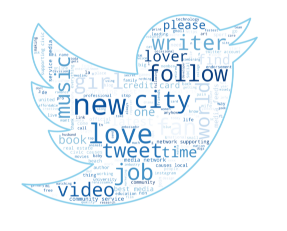

In [172]:
import os
from wordcloud import WordCloud
from os import path
from PIL import Image
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
tweet_mask = np.array(Image.open(path.join(d, "twi_bg.png")))


# Generate a word cloud image
wordcloud = WordCloud(background_color = 'white', max_font_size=500, height=1280, width = 2120,
                      colormap="Blues_r",mask=tweet_mask,
                     contour_color='skyblue', contour_width=50).generate(" ".join(corpus[:200]))
#wordcloud.to_file(path.join(d, "total.png"))
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 4663.5, 3711.5, -0.5)

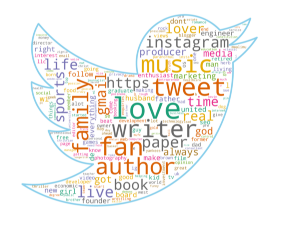

In [173]:
# Generate a word cloud image for males
wordcloud = WordCloud(background_color = 'white', max_font_size=500, height=1280, width = 2120,
                      colormap="Dark2",mask=tweet_mask,
                     contour_color='skyblue', contour_width=50).generate(" ".join(corpus_male[:200]))
wordcloud.to_file(path.join(d, "males.png"))
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 4663.5, 3711.5, -0.5)

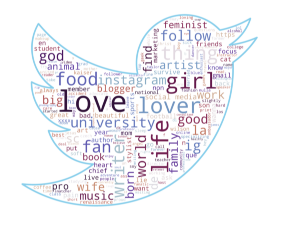

In [177]:
# Generate a word cloud image for females
wordcloud = WordCloud(background_color = 'white', max_font_size=500, height=400, width = 200,
                      colormap="twilight",mask=tweet_mask,
                     contour_color='skyblue', contour_width=50).generate(" ".join(corpus_female[:200]))
wordcloud.to_file(path.join(d, "females.png"))
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 4663.5, 3711.5, -0.5)

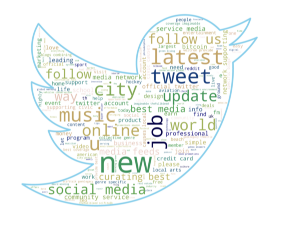

In [178]:
# Generate a word cloud image for brands
wordcloud = WordCloud(background_color = 'white', max_font_size=500, height=1280, width = 2120,
                      colormap="gist_earth",mask=tweet_mask,
                     contour_color='skyblue', contour_width=50).generate(" ".join(corpus_brand[:200]))
wordcloud.to_file(path.join(d, "brand.png"))
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [140]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000)
X = cv.fit_transform(corpus).toarray()
y = twitter_desc.iloc[:, -2].values
print(X.shape)

(11773, 5000)


## Train-Test Split

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Baseline accuracy -

In [142]:
n_male = sum(twitter_desc['gender'] == 'male')
print(n_male)

n_female = sum(twitter_desc['gender'] == 'female')
print(n_female)

n_brand = sum(twitter_desc['gender'] == 'brand')
print(n_brand)

baseline = max(n_male,n_female,n_brand)/(n_male+n_female+n_brand)
baseline

print("We need to beat 39% baseline accuracy!")

4150
4616
3007
We need to beat 39% baseline accuracy!


## Naive Bayes -

In [61]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
print("accuracy: ",gnb.score(X_test,y_test))

accuracy:  0.4348195329087049


## Multinomial Naive Bayes -

In [102]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# prediction
y_pred = mnb.predict(X_test)

ct = pd.crosstab(list(y_test),y_pred,margins=True)
ct
#accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
#accuracy

col_0,brand,female,male,All
row_0,,,,
brand,454,73,68,595
female,55,654,180,889
male,88,342,441,871
All,597,1069,689,2355


In [158]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t\t%.4f\t%-15s \t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
        
show_most_informative_features(cv, mnb)

		-9.4066	abc             		-5.2169	oo             
		-9.4066	abus            		-5.3992	environmentalist
		-9.4066	acceler         		-5.4747	question       
		-9.4066	accent          		-5.4747	clip           
		-9.4066	accept          		-5.6224	wellb          
		-9.4066	access          		-5.6930	joe            
		-9.4066	accessori       		-5.9101	filter         
		-9.4066	accommod        		-5.9408	valuabl        
		-9.4066	ace             		-6.1107	ut             
		-9.4066	achiev          		-6.1107	motor          
		-9.4066	activ           		-6.1107	humour         
		-9.4066	activist        		-6.1485	smith          
		-9.4066	actress         		-6.1485	rob            
		-9.4066	actual          		-6.1485	repair         
		-9.4066	adam            		-6.1485	ray            
		-9.4066	addict          		-6.1485	herb           
		-9.4066	addit           		-6.1485	golden         
		-9.4066	address         		-6.1485	elimin         
		-9.4066	ador            		-6.1485	dk             
		-9.4066	a

In [155]:
top

NameError: name 'top' is not defined

In [91]:
cv.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(max_features=5000, ngram_range=(2, 2))>

## Logistic Regression -

In [112]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=2000)
logit.fit(X_train,y_train)
# prediction
y_pred = logit.predict(X_test)

ct = pd.crosstab(list(y_test),y_pred,margins=True)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.6416135881104034

In [115]:
show_most_informative_features(cv, logit)

		2.2699	weather        
		1.6088	news           
		1.5011	us             
		1.4873	restaur        
		1.4401	jewelri        
		1.4211	organ          
		1.4204	resourc        
		1.4186	station        
		1.3816	offici         
		1.3790	continu        
		1.3767	inform         
		1.3614	reddit         
		1.3568	discov         
		1.3540	worldwid       
		1.3344	locat          
		1.3239	program        
		1.3113	bot            
		1.3046	auction        
		1.2976	buzz           
		1.2490	updat          


C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [143]:
for i in range(0,len(y_train)):
    if y_train[i] == 'brand':
        y_train[i] = 0
    elif y_train[i] == 'female':
        y_train[i] = 1
    elif y_train[i] == 'male':
        y_train[i] = 2

In [144]:
from xgboost import XGBClassifier
from xgboost import plot_tree

In [145]:

model = XGBClassifier(subsample = 0.7, max_depth = 14,
                      learning_rate = 0.22, n_estimators = 400)
model.fit(X_train, y_train)
print(model)




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.22, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [146]:
# Look at training and test accuracy -
y_pred_train = model.predict(X_train)
ct = pd.crosstab(list(y_train),y_pred_train,margins=True)
accuracy_train = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
print(accuracy_train)



y_pred = model.predict(X_test)

ct = pd.crosstab(list(y_test),y_pred,margins=True)
print(ct)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.8649394775960926
col_0     0     1    2   All
row_0                       
brand   412    89   94   595
female   39   670  180   889
male     67   360  444   871
All     518  1119  718  2355


0.6479830148619957

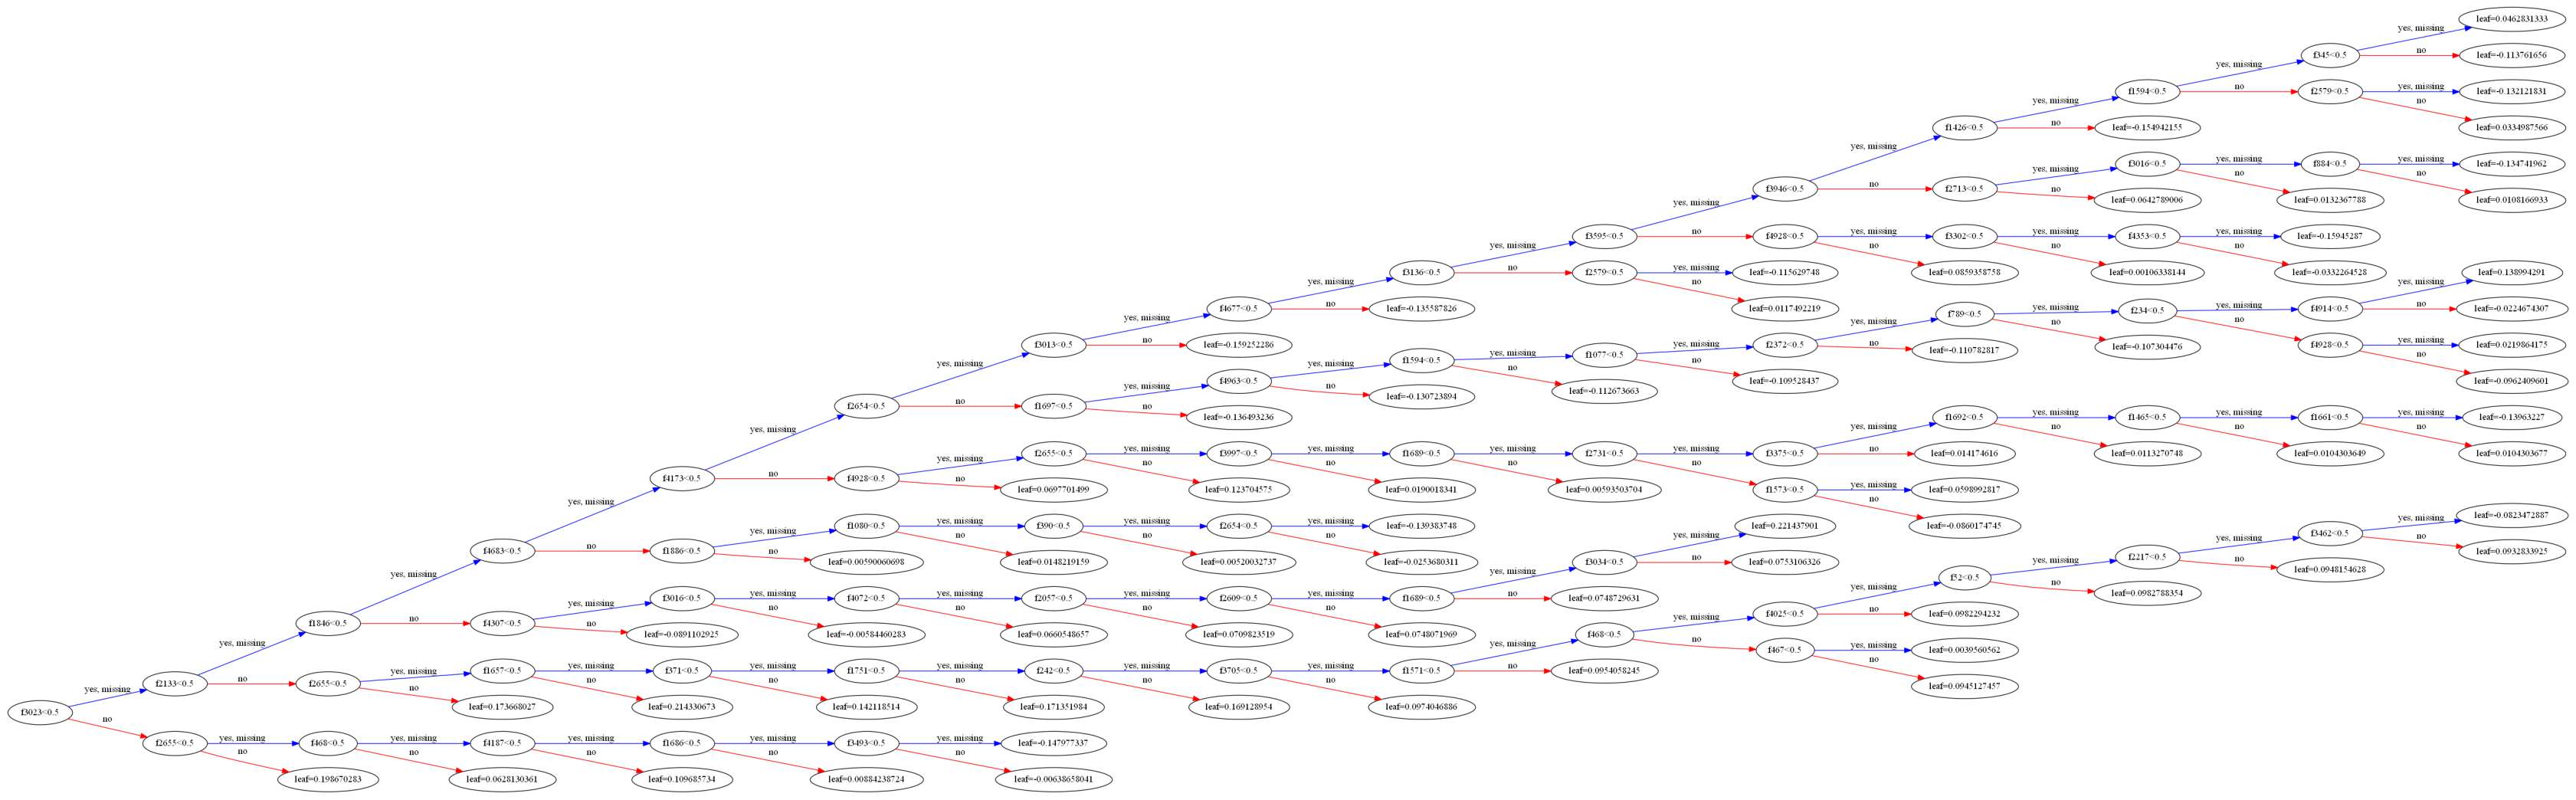

<Figure size 432x288 with 0 Axes>

In [154]:
fig, ax = plt.subplots(figsize=(60, 60))
plot_tree(model, num_trees=4, rankdir='LR', ax=ax)
plt.show()
plt.savefig("XGB.jpg")

In [7]:
# To look at stylistic features, lets look at sidebar color and link color -
# Remove NAs
import math

twitter_style = twitter_conf.dropna(subset=['link_color','sidebar_color'])
mask_wrong_color = list(twitter_style['sidebar_color'].map(lambda x: len(x)<=6)) or list(twitter_style['link_color'].map(lambda x: len(x)<=6))

twitter_style = twitter_style[mask_wrong_color]

arr_hex = "0x"+twitter_style.sidebar_color
arr_hex_link = "0x"+twitter_style.link_color


arr_int = arr_hex.map(lambda x: int(x, base=16))
arr_int_log = arr_int.map(lambda x: math.log(x+1))
arr_color_hex = arr_int.map(lambda x: hex(x))
twitter_style['arr_color_hex'] = arr_color_hex

twitter_style_male = twitter_style[twitter_style['gender']=='male']
twitter_style_female = twitter_style[twitter_style['gender']=='female']
twitter_style_brand = twitter_style[twitter_style['gender']=='brand']

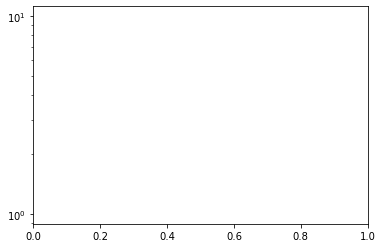

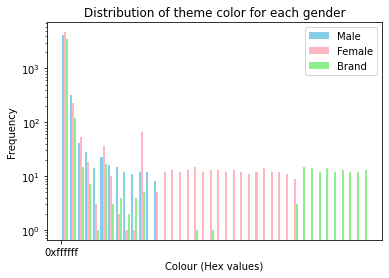

<Figure size 432x288 with 0 Axes>

In [20]:
# Male
plt.yscale('log')

col_male = twitter_style_male['arr_color_hex']
col_female = twitter_style_female['arr_color_hex']
col_brand = twitter_style_brand['arr_color_hex']
fig, ax = plt.subplots()
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1))
plt.yscale('log')
abc = plt.hist([col_male, col_female, col_brand], bins=40, align=('mid'), 
         color=['skyblue', 'lightpink','lightgreen'], label=['Male','Female','Brand'])
plt.legend()
plt.title("Distribution of theme color for each gender")
plt.xlabel("Colour (Hex values)")
plt.ylabel("Frequency")
plt.show()

plt.savefig("EDA_1.jpg")

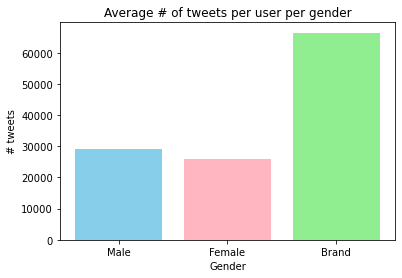

In [40]:
# Let's look at count of tweets per profile

count_male = sum(twitter_style['gender']=='male')
count_male


count_female = sum(twitter_style['gender']=='female')
count_female

count_brand = sum(twitter_style['gender']=='brand')
count_brand

plt.bar(["Male","Female", "Brand"],[sum(twitter_style_male.tweet_count)/count_male, 
                                    sum(twitter_style_female.tweet_count)/count_female, 
                                    sum(twitter_style_brand.tweet_count)/count_brand],
       color=['skyblue', 'lightpink','lightgreen'])
plt.title("Average # of tweets per user per gender")
plt.xlabel("Gender")
plt.ylabel("# tweets")
plt.savefig("EDA_2.jpg")

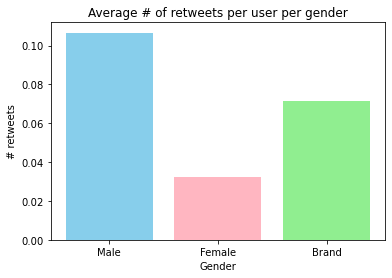

In [41]:
# Let's look at count of tweets per profile

count_male = sum(twitter_style['gender']=='male')
count_male


count_female = sum(twitter_style['gender']=='female')
count_female

count_brand = sum(twitter_style['gender']=='brand')
count_brand

plt.bar(["Male","Female", "Brand"],[sum(twitter_style_male.retweet_count)/count_male, 
                                    sum(twitter_style_female.retweet_count)/count_female, 
                                    sum(twitter_style_brand.retweet_count)/count_brand],
       color=['skyblue', 'lightpink','lightgreen'])
plt.title("Average # of retweets per user per gender")
plt.xlabel("Gender")
plt.ylabel("# retweets")
plt.savefig("EDA_3.jpg")

In [31]:
sum(twitter_style_male.tweet_count)

135620814

In [ ]:
# Brand

(array([2.515e+03, 3.600e+01, 8.680e+02, 4.700e+01, 2.000e+00, 1.000e+00,
        1.000e+00, 1.700e+01, 3.600e+01, 3.000e+01, 1.800e+01, 2.000e+00,
        9.000e+00, 1.000e+00, 2.000e+01, 1.800e+01, 1.000e+00, 3.000e+00,
        2.000e+00, 1.100e+01, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 6.000e+00, 1.100e+01, 1.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+0

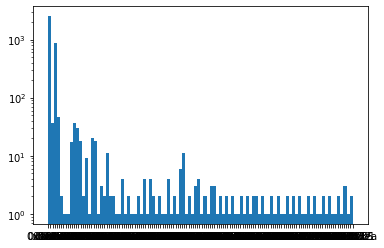

In [295]:
plt.yscale('log')
plt.hist(twitter_style_brand['arr_color_hex'], bins=100)

## Let's try Bigrams!!!

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000, ngram_range=(2,2))
Xn = cv.fit_transform(corpus).toarray()
yn = twitter_desc.iloc[:, -2].values
print(X.shape)

(11773, 5000)


In [117]:
from sklearn.model_selection import train_test_split
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size = 0.20, random_state = 0)

In [105]:
# Multinomial Naive Bayes -

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(Xn_train, yn_train)
# prediction
yn_pred = mnb.predict(Xn_test)

ct = pd.crosstab(list(yn_test),yn_pred,margins=True)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.540552016985138

In [106]:
show_most_informative_features(cv, mnb)

		-5.2169	offici twitter 
		-5.3992	follow us      
		-5.4747	price updat    
		-5.4747	continu price  
		-5.6224	visit http     
		-5.6930	latest news    
		-5.9101	gmail com      
		-5.9408	twitter account
		-6.1107	tweet us       
		-6.1107	need help      
		-6.1107	improv health  
		-6.1485	spiritu empow  
		-6.1485	secur improv   
		-6.1485	research prove 
		-6.1485	prove visit    
		-6.1485	http grfoxfjwpv
		-6.1485	health research
		-6.1485	financi secur  
		-6.1485	empow financi  
		-6.1877	social media   


C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [119]:
# Logistic regression -

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=1000)
logit.fit(Xn_train,yn_train)
# prediction
yn_pred = logit.predict(Xn_test)

ct = pd.crosstab(list(yn_test),yn_pred,margins=True)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.5430997876857749

In [120]:
show_most_informative_features(cv, logit)

		2.3242	follow us      
		1.8567	real time      
		1.8132	news reddit    
		1.8092	high qualiti   
		1.7395	latest news    
		1.7049	visit http     
		1.6649	non profit     
		1.6173	price updat    
		1.6173	continu price  
		1.5488	join us        
		1.5365	break news     
		1.5076	offici twitter 
		1.4382	one place      
		1.4131	custom servic  
		1.4017	jewelri design 
		1.3895	news updat     
		1.3884	check http     
		1.3817	news inform    
		1.3751	offici account 
		1.3551	radio station  


C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
# XGB!

for i in list(range(0,len(yn_train))):
    if yn_train[i] == 'brand':
        yn_train[i] = 0
    elif yn_train[i] == 'female':
        yn_train[i] = 1
    elif yn_train[i] == 'male':
        yn_train[i] = 2
#yxgb_train.reset_index(inplace=True)

for i in list(range(0,len(yn_test))):
    if yn_test[i] == 'brand':
        yn_test[i] = 0
    elif yn_test[i] == 'female':
        yn_test[i] = 1
    elif yn_test[i] == 'male':
        yn_test[i] = 2


In [73]:
xgb_n = XGBClassifier(subsample = 0.7, max_depth = 12,
                      learning_rate = 0.18, n_estimators = 400)
xgb_n.fit(Xn_train, yn_train)
print(xgb_n)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.18, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [74]:
yn_pred_train = xgb_n.predict(Xn_train)
ct = pd.crosstab(list(yn_train),yn_pred_train,margins=True)
accuracy_train = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
print(accuracy_train)



yn_pred = xgb_n.predict(Xn_test)

ct = pd.crosstab(list(yn_test),yn_pred,margins=True)
print(ct)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.6067105542578042
col_0    0     1    2   All
row_0                      
0      231   317   47   595
1       17   789   83   889
2       30   685  156   871
All    278  1791  286  2355


0.49936305732484076

## Let's try TF IDF Values!

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string 
# We need data in array of words format
def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords.words('english')]
    return text

In [138]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    twitter_desc['description'], twitter_desc['gender'], test_size = 0.20, random_state = 0)

yt_train
yt_train.unique()

array(['brand', 'female', 'male'], dtype=object)

In [77]:
# Let's vectorize!

tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=5000)
tfidf_vect_fit = tfidf_vect.fit(Xt_train)

tfidf_train = tfidf_vect_fit.transform(Xt_train)
tfidf_test = tfidf_vect_fit.transform(Xt_test)

X_train_vect = pd.DataFrame(tfidf_train.toarray())
X_test_vect = pd.DataFrame(tfidf_test.toarray())

In [78]:
# Multinomial Naive Bayes -

mnb_t = MultinomialNB()
mnb_t.fit(X_train_vect, yt_train)
# prediction
yt_pred = mnb_t.predict(X_test_vect)

ct = pd.crosstab(list(yt_test),yt_pred,margins=True)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.6543524416135881

In [107]:
show_most_informative_features(tfidf_vect, mnb_t)

		-4.8492	news           
		-5.6596	us             
		-5.6614	follow         
		-5.6693	updat          
		-5.7876	tweet          
		-5.7887	offici         
		-5.8431	twitter        
		-5.8588	latest         
		-6.0616	world          
		-6.0656	servic         
		-6.0710	price          
		-6.0756	account        
		-6.1177	continu        
		-6.1285	best           
		-6.1293	busi           
		-6.1617	help           
		-6.2061	new            
		-6.2628	free           
		-6.2792	provid         
		-6.2883	game           


C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [135]:
# Random FOrest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

rfc = RandomForestClassifier()

In [139]:
n_estimators = [i for i in range(260, 300, 10)]
max_depth = [i for i in range(8,12 , 2)]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

grid_search = GridSearchCV(rfc, param_grid, scoring='accuracy', cv=5)
grid_result = grid_search.fit(X_train_vect, yt_train)

result_rfc = pd.DataFrame(grid_result.cv_results_)

KeyboardInterrupt: 

In [130]:
best_rfc = grid_search.best_estimator_
yt_pred = best_rfc.predict(X_test_vect)
print(recall_score(yt_test, yt_pred, average='micro'))

NameError: name 'grid_search' is not defined

In [122]:
yxgb_train = yt_train
yxgb_train.index
for i in list(yxgb_train.index):
    if yxgb_train[i] == 'brand':
        yxgb_train[i] = 0
    elif yxgb_train[i] == 'female':
        yxgb_train[i] = 1
    elif yxgb_train[i] == 'male':
        yxgb_train[i] = 2
#yxgb_train.reset_index(inplace=True)

yxgb_test = yt_test
for i in list(yxgb_test.index):
    if yxgb_test[i] == 'brand':
        yxgb_test[i] = 0
    elif yxgb_test[i] == 'female':
        yxgb_test[i] = 1
    elif yxgb_test[i] == 'male':
        yxgb_test[i] = 2

yt_train

3849     0
7685     0
8593     0
11569    1
9468     0
        ..
4859     0
3264     0
9845     0
10799    1
2732     1
Name: gender, Length: 9418, dtype: object

In [263]:

# Power of XGB!


xgb = XGBClassifier(subsample = 0.6, max_depth = 8,
                      learning_rate = 0.18, n_estimators = 200)
xgb.fit(X_train_vect, yxgb_train)
print(xgb)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.18, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [262]:
# Look at training and test accuracy -
yxgb_pred_train = xgb.predict(X_train_vect)
ct = pd.crosstab(list(yxgb_train),yxgb_pred_train,margins=True)
accuracy_train = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
print(accuracy_train)



yxgb_pred = xgb.predict(X_test_vect)

ct = pd.crosstab(list(yxgb_test),yxgb_pred,margins=True)
print(ct)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.8416861329369293
col_0    0     1    2   All
row_0                      
0      405    98   92   595
1       31   675  183   889
2       54   386  431   871
All    490  1159  706  2355


0.6416135881104034

In [126]:
plot_tree(xgb, num_trees=0, rankdir='LR')

NameError: name 'plot_tree' is not defined

In [123]:
# Logistic regression -

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=2000)
logit.fit(X_train_vect,yn_train)
# prediction
yxgb_pred = logit.predict(X_test_vect)

ct = pd.crosstab(list(yxgb_test),yxgb_pred,margins=True)
accuracy = (ct.iloc[0,0]+ct.iloc[1,1]+ct.iloc[2,2])/ct.iloc[3,3]
accuracy

0.6462845010615711

In [125]:
show_most_informative_features(tfidf_vect, logit)

		4.7117	news           
		3.2619	us             
		2.6869	offici         
		2.5676	servic         
		2.3902	inform         
		2.3762	updat          
		2.1770	provid         
		2.0413	visit          
		2.0398	weather        
		1.9917	locat          
		1.9156	help           
		1.8949	latest         
		1.8881	station        
		1.8543	websit         
		1.8436	price          
		1.7326	event          
		1.7079	program        
		1.6955	shop           
		1.6882	organ          
		1.6844	bring          
